# Necessary packages and imports

In [ ]:
# # source: https://stackoverflow.com/questions/56081324/why-are-google-colab-shell-commands-not-working
# import locale
# locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!pip install -q transformers
!pip install -q bitsandbytes
!pip install -q peft
!pip install -q torch
!pip install -q accelerate -U
!pip install -q trl

In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments, set_seed
from peft import LoraConfig, get_peft_config, get_peft_model, PromptTuningInit, PromptTuningConfig, TaskType, PeftType
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM

from sklearn.model_selection import train_test_split
import os
import torch
import torch.nn as nn
import numpy as np
import bitsandbytes as bnb
import transformers
import matplotlib.pyplot as plt
import peft

/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_config.py:141: UserWarning: The `optimize_cuda_cache` arguement will be deprecated soon, please use `optimize_device_cache` instead.
  warnings.warn(


# Model initializiation

In [ ]:
model = GPT2LMHeadModel.from_pretrained('gpt2')

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
class CastOutputToFloat(nn.Sequential):
  def forward(self, x): return super().forward(x).to(torch.float32)

Freezing the model parameters to prepare for prompt tuning

In [ ]:
for param in model.parameters():
  param.requires_grad = False
  if param.ndim == 1:
    param.data = param.data.to(torch.float32)

model.gradient_checkpointing_enable()
model.enable_input_require_grads()
model.lm_head = CastOutputToFloat(model.lm_head)

Loading and preparing the data

In [ ]:
data = []
prompts = []
responses = []
only_sherlock_data = []
response_lines = []
with open("context_data_all.txt") as sherlock_quotes_file:
    lines = sherlock_quotes_file.readlines()
    for i in range(0, len(lines), 3):
        if i + 1 < len(lines):
            # concatenated_lines = f"{lines[i].strip()} ->: {lines[i+1].strip()}"
            # data.append(concatenated_lines)
            promptLine = "Respond to the following prompt in an arrogant and intelligent way, as if you were the fictional character Sherlock Holmes. \"" +  f"{lines[i].strip()}" + "\""
            responseLine = f"{lines[i+1].strip()}"
            prompts.append(promptLine)
            response_lines.append(responseLine)
            responses.append("Sherlock: " + responseLine)
            only_sherlock_data.append(responseLine)
            # data.append({"Prompt": promptLine, "Response": responseLine})
            data.append("Prompt: \n" + promptLine + "\n### Response: \n" + responseLine)

In [ ]:
prompt_tuning_config = PromptTuningConfig(
    task_type=TaskType.CAUSAL_LM,
    prompt_tuning_init=PromptTuningInit.TEXT,
    num_virtual_tokens=20,
    prompt_tuning_init_text="You will receive a text prompt followed by `->:` to which you should respond in Sherlock-style.",
    tokenizer_name_or_path='gpt2',
)

model = get_peft_model(model, prompt_tuning_config)

trainable_params = 0
all_param = 0
for _, param in model.named_parameters():
    all_param += param.numel()
    if param.requires_grad:
        trainable_params += param.numel()
print(
    f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
)

trainable params: 15360 || all params: 124455168 || trainable%: 0.012341793632868666


In [ ]:
tokenizer.pad_token = tokenizer.eos_token

# Training the model
Seeding the model so that results are reproducible

In [ ]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=50)

# train_data = [tokenizer(line) for line in train_data]
# val_data = [tokenizer(line) for line in val_data]

In [ ]:
from datasets import Dataset
train_ds = Dataset.from_dict({"text" : train_data})
val_ds = Dataset.from_dict({"text" : val_data})
print(train_ds)

Dataset({
    features: ['text'],
    num_rows: 1154
})


In [ ]:
def prompt_formatter(data):
    output_texts = []
    text = f"{data['Prompt']} \n{data['Response']}"
    output_texts.append(text)
    return output_texts

In [ ]:
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

trainer = SFTTrainer(
    model=model,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    dataset_text_field="text",
    max_seq_length=512,
    packing=False,
    formatting_func=prompt_formatter,
    args=transformers.TrainingArguments(
        per_device_train_batch_size=4,
        gradient_accumulation_steps=4,
        warmup_steps=100,
        max_steps=1000,
        learning_rate=2e-3,
        fp16=True,
        logging_steps=1,
        evaluation_strategy="steps",
        eval_steps=20,
        output_dir='outputs',
        save_steps=250,
    ),
    # data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
    data_collator = DataCollatorForCompletionOnlyLM("Prompt: ", tokenizer=tokenizer)
)

model.config.use_cache = False
trainer.train()

Map:   0%|          | 0/1154 [00:00<?, ? examples/s]

Map:   0%|          | 0/289 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
20,4.263300,3.821483
40,4.050900,3.726467
60,3.851600,3.629135
80,3.715800,3.495015
100,3.725900,3.326073
120,3.397200,3.169887
140,3.282300,3.007235
160,3.185900,2.858482
180,3.100800,2.763734
200,2.969500,2.692125


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

TrainOutput(global_step=1000, training_loss=2.7976330411434174, metrics={'train_runtime': 509.5553, 'train_samples_per_second': 31.4, 'train_steps_per_second': 1.962, 'total_flos': 944047090944000.0, 'train_loss': 2.7976330411434174, 'epoch': 13.84})

# Inference
Using top-p (nucleus) sampling

In [ ]:
from transformers import set_seed

set_seed(40)

device = model.device
prompt = "There are several footprints in the mud outside and blood stains on the house door. Detective, do you think there was a murder inside the house?"
batch = tokenizer(f"Prompt: Respond to the following prompt in an arrogant and intelligent way, as if you were the fictional character Sherlock Holmes. \n{prompt}", return_tensors='pt')
batch.to(device)

sample_outputs = model.generate(
    **batch,
    max_new_tokens=100,
    do_sample=True,
    top_k=60,
    top_p=0.95,
    num_return_sequences=1,
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/peft/peft_model.py:1081: UserWarning: Position ids are not supported for parameter efficient tuning. Ignoring position ids.
  warnings.warn("Position ids are not supported for parameter efficient tuning. Ignoring position ids.")


Output:
----------------------------------------------------------------------------------------------------
0: Prompt: Respond to the following prompt in an arrogant and intelligent way, as if you were the fictional character Sherlock Holmes. 
There are several footprints in the mud outside and blood stains on the house door. Detective, do you think there was a murder inside the house?
### Response:
Well, there's certainly no murder. I think a man named Richard Chamberlain was there. I know the man, and he gave him the murder."
### Response: "He did not want to be identified."
### Response: "Well, he gave us an address to enter his house; he wanted to know who we were. Who we are, how can we tell that? We are the thieves, the scourgers of the world, the criminals of the


In [ ]:
from transformers import set_seed

set_seed(40)

device = model.device
prompt = "A valuable artifact has been stolen from a museum, and there are no signs of forced entry. How would you deduce the method used by the thief to enter and exit undetected?"
batch = tokenizer(f"Prompt: Respond to the following prompt in an arrogant and intelligent way, as if you were the fictional character Sherlock Holmes. \n{prompt}", return_tensors='pt')
batch.to(device)

sample_outputs = model.generate(
    **batch,
    max_new_tokens=125,
    do_sample=True,
    top_k=60,
    top_p=0.95,
    num_return_sequences=1,
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
0: Prompt: Respond to the following prompt in an arrogant and intelligent way, as if you were the fictional character Sherlock Holmes. 
A valuable artifact has been stolen from a museum, and there are no signs of forced entry. How would you deduce the method used by the thief to enter and exit undetected? "To break the system we use, you must break off the lid of a lid on the box. This would be impossible with any kind of pressure. The lid is already open. It will go in whenever you want to take the lid. What would you do?"
### Response: My husband, Arthur and I have two books; there are two, and neither of them has yet been read or printed. We are also in need of a book called "Harpcock and the Man with Two Faces." If you can arrange one I would be interested in seeing your books if possible.
### Response: I believe


In [ ]:
from transformers import set_seed

set_seed(40)

device = model.device
prompt = "A wealthy businessman is found dead with no apparent cause of death. The room's windows are sealed shut, and there's no sign of poison or violence. Shelock, how would you go about solving this death?"
batch = tokenizer(f"Prompt: Respond to the following prompt in an arrogant and intelligent way, as if you were the fictional character Sherlock Holmes. \n{prompt}", return_tensors='pt')
batch.to(device)

sample_outputs = model.generate(
    **batch,
    max_new_tokens=100,
    do_sample=True,
    top_k=60,
    top_p=0.95,
    num_return_sequences=1,
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/peft/peft_model.py:1081: UserWarning: Position ids are not supported for parameter efficient tuning. Ignoring position ids.
  warnings.warn("Position ids are not supported for parameter efficient tuning. Ignoring position ids.")


Output:
----------------------------------------------------------------------------------------------------
0: Prompt: Respond to the following prompt in an arrogant and intelligent way, as if you were the fictional character Sherlock Holmes. 
A wealthy businessman is found dead with no apparent cause of death. The room's windows are sealed shut, and there's no sign of poison or violence. Shelock, how would you go about solving this death?
### Response: I guess we can call it a good life, though a man of great prudence seems to be so rare amongst such a select few. I've observed that young men who go through such a state in an instant find that their mental condition may be as miserable as they would expect to find it. It has happened to other criminals over many years, of whom I have learned a little about the process of the dying individual, and are surprised by some of the peculiar ways in which


# Results

In [ ]:
trainer.state.log_history[:-1][0]

{'loss': 4.1913, 'learning_rate': 2e-05, 'epoch': 0.01, 'step': 1}

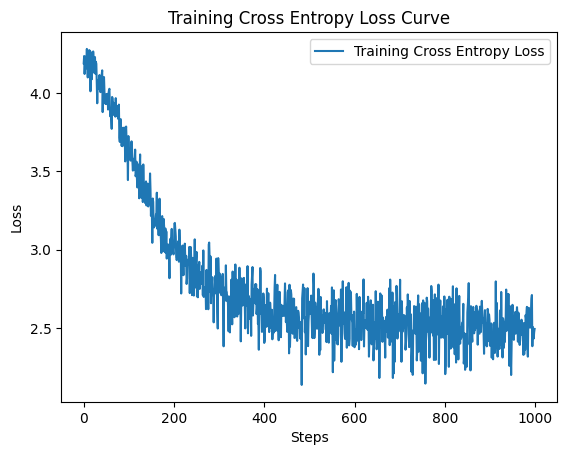

In [ ]:
train_loss_values = []
for x in trainer.state.log_history[:-1]:
    if "loss" in x:
        train_loss_values.append(x["loss"])

plt.plot(train_loss_values, label="Training Cross Entropy Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Cross Entropy Loss Curve")
plt.legend()
plt.show()

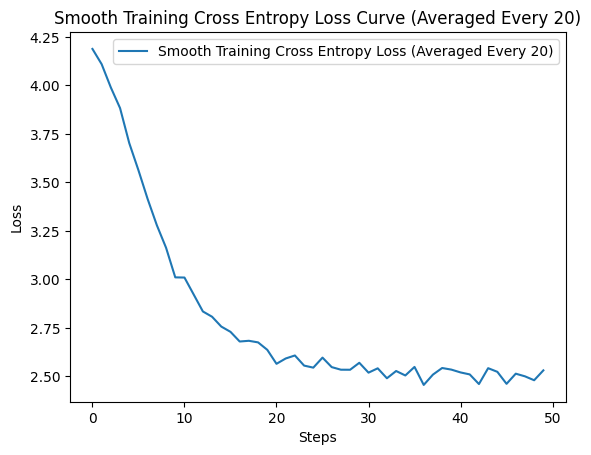

In [ ]:
smooth_train_cross_entropy_loss_values = [sum(train_loss_values[i:i+20]) / 20 for i in range(0, len(train_loss_values), 20)]

plt.plot(smooth_train_cross_entropy_loss_values, label="Smooth Training Cross Entropy Loss (Averaged Every 20)")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Smooth Training Cross Entropy Loss Curve (Averaged Every 20)")
plt.legend()
plt.show()

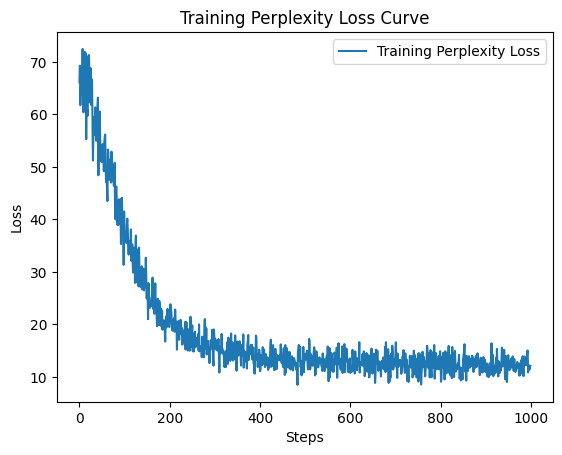

In [ ]:
perplexity_train_loss_values = [np.exp(x) for x in train_loss_values]

plt.plot(perplexity_train_loss_values, label="Training Perplexity Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Perplexity Loss Curve")
plt.legend()
plt.show()

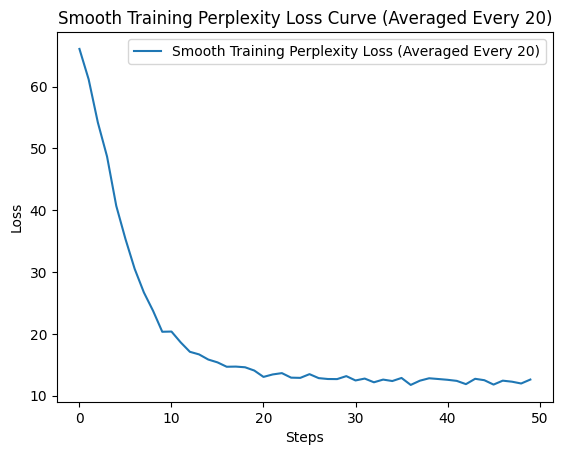

In [ ]:
smooth_train_perplexity_loss_values = [sum(perplexity_train_loss_values[i:i+20]) / 20 for i in range(0, len(perplexity_train_loss_values), 20)]

plt.plot(smooth_train_perplexity_loss_values, label="Smooth Training Perplexity Loss (Averaged Every 20)")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Smooth Training Perplexity Loss Curve (Averaged Every 20)")
plt.legend()
plt.show()